# Install Packages

In [ ]:
# # install finrl library
# !pip install wrds
# !pip install swig
# !pip install -q condacolab
# !apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
# !pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

In [ ]:
# !pip install yfinance
# !pip install edgartools
# !pip install py-xbrl

In [4]:
import yfinance as yf
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
import numpy as np
import matplotlib
%matplotlib inline
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import requests
import json
import random
import cvxpy
# from cvxpy import *
import gym
from gym.utils import seeding
from gym import spaces
import os
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import ParameterGrid

In [5]:
# from finrl import config
# from finrl import config_tickers
# from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
# from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
# from finrl.meta.env_portfolio_allocation.env_portfolio import StockPortfolioEnv
from finrl.agents.stablebaselines3.models import DRLAgent
# from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline,convert_daily_return_to_pyfolio_ts
# from finrl.meta.data_processor import DataProcessor
# from finrl.meta.data_processors.processor_yahoofinance import YahooFinanceProcessor
from stable_baselines3.common.vec_env import DummyVecEnv

# Data Wrangling

We decided to look at diversifying our portfolio constituents rather than specifically focusing on mining companies. We're going to look at the S&P 500 Dividend Aristocrats. This is an index of the S&P 500 constituents that have increased their dividend yearly for at least the last 25 years. As of today, 03/26/2024, there are 67 companies in this index. Note that this is not a point-in-time representation of the index. Rather, we're taking the current list of 67 constituents, and building our own index with these 67 diversified companies from a past start time.

In [6]:
sp_da = pd.read_html('https://en.wikipedia.org/wiki/S%26P_500_Dividend_Aristocrats')[0]
tickers = sp_da['Ticker symbol'].str.replace('.', '-').tolist()

# View sector distribution
sector_distribution = pd.DataFrame(sp_da.groupby(['Sector']).count()['Company'])

sector_distribution.loc['TOTAL'] = sector_distribution.sum()

sector_distribution

,Company
Sector,
Consumer Discretionary,4
Consumer Staples,15
Energy,2
Financials,7
Health Care,7
Industrials,15
Information Technology,2
Materials,8
Real Estate,3


As of today, the dividend aristocrats include 67 companies in 10 sectors. This shows that diversification is feasible within that group of assets.

In [7]:
start_date = "2000-01-01"
end_date = "2024-04-07"

data = yf.download(
    tickers,
    start=start_date,
    end=end_date,
    auto_adjust=True)['Close']

data

[                       0%                       ]

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:718: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:718: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:718: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:718: Futu

[***                    6%                       ]  4 of 66 completed

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:718: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:718: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:718: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:718: Futu

[******                12%                       ]  8 of 66 completed

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:718: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:718: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:718: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


[********              17%                       ]  11 of 66 completed

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:718: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


[*********             18%                       ]  12 of 66 completed

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:718: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:718: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:718: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


[**********            20%                       ]  13 of 66 completed

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:718: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:718: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


[************          26%                       ]  17 of 66 completed

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:718: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:718: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


[**************        29%                       ]  19 of 66 completed

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:718: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


[**************        30%                       ]  20 of 66 completed

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:718: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


[***************       32%                       ]  21 of 66 completed

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:718: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:718: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


[*****************     35%                       ]  23 of 66 completed

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:718: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:718: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


[*****************     36%                       ]  24 of 66 completed

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:718: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:718: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:718: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:718: Futu

[********************* 44%                       ]  29 of 66 completed

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:718: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:718: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:718: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:718: Futu

[**********************52%                       ]  34 of 66 completed

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:718: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:718: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


[**********************55%*                      ]  36 of 66 completed

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:718: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:718: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


[**********************58%***                    ]  38 of 66 completed

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:718: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:718: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


[**********************59%***                    ]  39 of 66 completed

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:718: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


[**********************61%****                   ]  40 of 66 completed

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:718: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


[**********************62%*****                  ]  41 of 66 completed

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:718: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


[**********************65%******                 ]  43 of 66 completed

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:718: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:718: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


[**********************68%********               ]  45 of 66 completed

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:718: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:718: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


[**********************70%*********              ]  46 of 66 completed

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:718: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


[**********************71%*********              ]  47 of 66 completed

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:718: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:718: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:718: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


[**********************76%***********            ]  50 of 66 completed

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:718: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


[**********************77%************           ]  51 of 66 completed

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:718: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


[**********************80%*************          ]  53 of 66 completed

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:718: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:718: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


[**********************82%**************         ]  54 of 66 completed

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:718: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


[**********************85%****************       ]  56 of 66 completed

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:718: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:718: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


[**********************88%*****************      ]  58 of 66 completed

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:718: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:718: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


[**********************89%******************     ]  59 of 66 completed

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:718: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:718: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


[**********************92%*******************    ]  61 of 66 completed

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:718: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:718: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


[**********************97%********************** ]  64 of 66 completed

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:718: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:718: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


[*********************100%***********************]  66 of 66 completed

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:718: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


,ABBV,ABT,ADM,ADP,AFL,ALB,AMCR,AOS,APD,ATO,...,SHW,SJM,SPGI,SWK,SYY,TGT,TROW,WMT,WST,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,NaN,8.99,6.41,24.78,6.92,6.17,NaN,2.33,17.21,8.03,...,4.60,9.56,18.91,15.58,10.29,22.67,9.41,14.47,5.43,18.33
2000-01-04,NaN,8.74,6.35,24.78,6.73,6.17,NaN,2.30,16.69,7.83,...,4.43,9.44,18.04,15.24,9.97,21.69,9.13,13.93,5.48,17.98
2000-01-05,NaN,8.72,6.25,24.54,6.70,6.28,NaN,2.29,16.79,8.08,...,4.44,9.37,17.80,15.04,10.09,21.20,9.11,13.64,5.46,18.96
2000-01-06,NaN,9.02,6.28,24.87,6.83,6.49,NaN,2.26,17.90,7.96,...,4.51,9.56,17.31,14.97,10.51,20.19,9.38,13.79,5.40,19.94
2000-01-07,NaN,9.12,6.38,25.44,6.97,6.39,NaN,2.35,19.15,8.03,...,4.46,9.62,17.47,15.24,10.53,21.24,9.31,14.83,5.46,19.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-01,179.09,111.54,62.35,245.31,85.19,129.18,9.45,88.74,243.42,117.85,...,338.16,124.73,427.09,95.46,80.07,177.82,120.30,60.00,395.73,116.99
2024-04-02,179.02,111.47,62.70,247.66,84.93,126.48,9.31,88.21,239.84,117.77,...,333.96,123.06,426.11,94.49,79.93,176.24,118.55,59.16,387.69,119.28
2024-04-03,175.69,110.73,62.65,245.13,85.18,128.87,9.18,88.31,239.60,116.97,...,334.29,119.52,426.46,96.24,79.45,175.49,118.49,59.43,386.94,119.30


et's try to identify start and end dates for each of these constituents to determine if we feel like there's enough data for each

In [ ]:
# Plot the time series for each ticker
fig, ax = plt.subplots(figsize=(18, 12))  # Increase figure size for better readability
for ticker in data.columns:
  ax.plot(data.index, data[ticker], label=ticker)

# Customize the plot
ax.set_xlabel('Date')
ax.set_ylabel('Closing Price')
ax.set_title('Closing Prices Over Time')
ax.legend()

# Rotating the x-axis label to make them more readable
plt.xticks(rotation=45)
plt.tight_layout()
# plt.s


In [8]:
price_date_range = pd.DataFrame()
price_date_range['Start Date'] = data.apply(lambda x:x.first_valid_index())
price_date_range['End Date'] = data.apply(lambda x:x.last_valid_index())

price_date_range.sort_values(by='Start Date', ascending=False)

,Start Date,End Date
KVUE,2023-05-04,2024-04-05
ABBV,2013-01-02,2024-04-05
AMCR,2012-05-15,2024-04-05
IBM,2000-01-03,2024-04-05
ITW,2000-01-03,2024-04-05
...,...,...
ESS,2000-01-03,2024-04-05
EXPD,2000-01-03,2024-04-05
FAST,2000-01-03,2024-04-05
FRT,2000-01-03,2024-04-05


Count how many tickers don't have data available until the end of the period.

In [9]:
# any tickers that get dropped before the current EndDate
data.iloc[-1].isnull().sum()

0

Drop all tickers that start later than 2000-01-03 or have no data until the end of the period. Update `tickers` variable.

In [10]:
data = data.loc[:, data.iloc[-1].notnull() & data.iloc[0].notnull()]
tickers = list(data.columns)

data # should be 64 columns now

,ABT,ADM,ADP,AFL,ALB,AOS,APD,ATO,BDX,BEN,...,SHW,SJM,SPGI,SWK,SYY,TGT,TROW,WMT,WST,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,8.99,6.41,24.78,6.92,6.17,2.33,17.21,8.03,17.60,5.68,...,4.60,9.56,18.91,15.58,10.29,22.67,9.41,14.47,5.43,18.33
2000-01-04,8.74,6.35,24.78,6.73,6.17,2.30,16.69,7.83,17.14,5.58,...,4.43,9.44,18.04,15.24,9.97,21.69,9.13,13.93,5.48,17.98
2000-01-05,8.72,6.25,24.54,6.70,6.28,2.29,16.79,8.08,17.26,5.67,...,4.44,9.37,17.80,15.04,10.09,21.20,9.11,13.64,5.46,18.96
2000-01-06,9.02,6.28,24.87,6.83,6.49,2.26,17.90,7.96,17.98,6.01,...,4.51,9.56,17.31,14.97,10.51,20.19,9.38,13.79,5.40,19.94
2000-01-07,9.12,6.38,25.44,6.97,6.39,2.35,19.15,8.03,18.98,6.06,...,4.46,9.62,17.47,15.24,10.53,21.24,9.31,14.83,5.46,19.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-01,111.54,62.35,245.31,85.19,129.18,88.74,243.42,117.85,244.05,27.62,...,338.16,124.73,427.09,95.46,80.07,177.82,120.30,60.00,395.73,116.99
2024-04-02,111.47,62.70,247.66,84.93,126.48,88.21,239.84,117.77,241.02,27.28,...,333.96,123.06,426.11,94.49,79.93,176.24,118.55,59.16,387.69,119.28
2024-04-03,110.73,62.65,245.13,85.18,128.87,88.31,239.60,116.97,243.59,27.50,...,334.29,119.52,426.46,96.24,79.45,175.49,118.49,59.43,386.94,119.30


In [11]:
# let's turn prices into log returns
rets = np.log(data).diff()
rets = rets.dropna()
rets

,ABT,ADM,ADP,AFL,ALB,AOS,APD,ATO,BDX,BEN,...,SHW,SJM,SPGI,SWK,SYY,TGT,TROW,WMT,WST,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-04,-0.03,-0.01,0.00,-0.03,0.00,-0.01,-0.03,-0.03,-0.03,-0.02,...,-0.04,-0.01,-0.05,-0.02,-0.03,-0.04,-0.03,-0.04,0.01,-0.02
2000-01-05,-0.00,-0.02,-0.01,-0.01,0.02,-0.00,0.01,0.03,0.01,0.02,...,0.00,-0.01,-0.01,-0.01,0.01,-0.02,-0.00,-0.02,-0.00,0.05
2000-01-06,0.03,0.01,0.01,0.02,0.03,-0.01,0.06,-0.02,0.04,0.06,...,0.02,0.02,-0.03,-0.00,0.04,-0.05,0.03,0.01,-0.01,0.05
2000-01-07,0.01,0.02,0.02,0.02,-0.02,0.04,0.07,0.01,0.05,0.01,...,-0.01,0.01,0.01,0.02,0.00,0.05,-0.01,0.07,0.01,-0.00
2000-01-10,-0.01,0.00,0.02,-0.06,-0.00,0.01,-0.06,-0.01,-0.02,0.01,...,-0.02,-0.01,0.07,-0.01,0.00,-0.02,0.01,-0.02,0.02,-0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-01,-0.01,-0.01,-0.02,-0.01,-0.02,-0.00,0.00,-0.01,-0.01,-0.02,...,-0.03,-0.01,0.00,-0.03,-0.01,0.00,-0.01,-0.00,0.00,0.01
2024-04-02,-0.00,0.01,0.01,-0.00,-0.02,-0.01,-0.01,-0.00,-0.01,-0.01,...,-0.01,-0.01,-0.00,-0.01,-0.00,-0.01,-0.01,-0.01,-0.02,0.02
2024-04-03,-0.01,-0.00,-0.01,0.00,0.02,0.00,-0.00,-0.01,0.01,0.01,...,0.00,-0.03,0.00,0.02,-0.01,-0.00,-0.00,0.00,-0.00,0.00


# Include additional data

In [12]:
# first need to pivot the rets df
rets_long = pd.DataFrame(rets.stack())
rets_long = rets_long.reset_index()
rets_long = rets_long.rename(columns={0: 'ret'})
rets_long.head()

,Date,level_1,ret
0,2000-01-04,ABT,-0.03
1,2000-01-04,ADM,-0.01
2,2000-01-04,ADP,0.00
3,2000-01-04,AFL,-0.03
4,2000-01-04,ALB,0.00


## Fundamentals

In [13]:
root_dir = "/content/drive/My Drive/CapstoneProject/data/fundamental"

In [14]:
# dividend yield = dividends per share/current share price --> dividendPayout and commonStockSharesOutstanding and price from yfinance
# payout ratio = total dividends / net income --> dividendPayout and netIncome
# operating cash flow ratio = operating cash flow / net revenue --> operatingCashflow and totalRevenue and costOfRevenue
# return on assets = net income / total assets --> netIncome and totalAssets
# net profit margin = net income / revenue --> netIncome and totalRevenue

In [15]:
# let's look at a few tickers first before we try to combine everything
tic = 'MMM'
income_statement = pd.read_csv(f'{root_dir}/IncomeStatement/{tic}_IS.csv')
balance_sheet = pd.read_csv(f'{root_dir}/BalanceSheet/{tic}_BS.csv')
cash_flow = pd.read_csv(f'{root_dir}/CashFlow/{tic}_CF.csv')
df = pd.merge(income_statement, balance_sheet, on='fiscalDateEnding', how='outer').merge(cash_flow, on='fiscalDateEnding', how='outer')
df = df.sort_values('fiscalDateEnding')
df.head(6)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/CapstoneProject/data/fundamental/IncomeStatement/MMM_IS.csv'

In [ ]:
tic = 'MKC'
income_statement = pd.read_csv(f'{root_dir}/IncomeStatement/{tic}_IS.csv')
balance_sheet = pd.read_csv(f'{root_dir}/BalanceSheet/{tic}_BS.csv')
cash_flow = pd.read_csv(f'{root_dir}/CashFlow/{tic}_CF.csv')
df = pd.merge(income_statement, balance_sheet, on='fiscalDateEnding', how='outer').merge(cash_flow, on='fiscalDateEnding', how='outer')
df = df.sort_values('fiscalDateEnding')
df.head(6)

,fiscalDateEnding,grossProfit,totalRevenue,costOfRevenue,costofGoodsAndServicesSold,operatingIncome,sellingGeneralAndAdministrative,researchAndDevelopment,operatingExpenses,investmentIncomeNet,...,dividendPayoutCommonStock,dividendPayoutPreferredStock,proceedsFromIssuanceOfCommonStock,proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet,proceedsFromIssuanceOfPreferredStock,proceedsFromRepurchaseOfEquity,proceedsFromSaleOfTreasuryStock,changeInCashAndCashEquivalents,changeInExchangeRate,netIncome_y
0,2009-08-31,319000000,791700000,472700000,472700000,116600000,201500000,NaN,201500000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2009-11-30,421700000,924600000,502900000,502900000,177900000,238300000,48900000.00,238300000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-02-28,310200000,764500000,454300000,454300000,100800000,209400000,NaN,209400000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2010-05-31,326700000,798300000,471600000,471600000,97500000,229200000,NaN,229200000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010-08-31,334800000,782200000,668600000,459800000,126000000,208800000,NaN,221200000,NaN,...,34700000.00,NaN,NaN,NaN,NaN,-31800000.00,NaN,500000.00,15600000.00,102400000.00
5,2010-11-30,446000000,979500000,794000000,533400000,185400000,260600000,52700000.00,272800000,NaN,...,34500000.00,NaN,NaN,NaN,NaN,-16600000.00,NaN,27200000.00,16600000.00,133600000.00


## We notice a few things


*   Time scales are different (notice that MMM reported on 2009-09-30 and MKC reported on 2009-08-31)
*   They have a much later time start than our price data.
*   They have different start dates.
*   They have different amounts of NaN at different features.

The first bullet will be handled with re-scaling the data. The remaining bullets will all affect our ultimate start date, and we'll have to getter a better sense for the data available in the other tickers.

In [ ]:
master_df = pd.DataFrame()

for tic in tickers:
  print(f'Processing {tic}...')
  income_statement = pd.read_csv(f'{root_dir}/IncomeStatement/{tic}_IS.csv')
  balance_sheet = pd.read_csv(f'{root_dir}/BalanceSheet/{tic}_BS.csv')
  cash_flow = pd.read_csv(f'{root_dir}/CashFlow/{tic}_CF.csv')
  df = pd.merge(income_statement, balance_sheet, on='fiscalDateEnding', how='outer').merge(cash_flow, on='fiscalDateEnding', how='outer')
  df = df.rename(columns={'fiscalDateEnding': 'Date'})
  df = df.sort_values('Date')
  df.set_index('Date', inplace=True)
  df.index = pd.to_datetime(df.index)
  df = df.resample('Q').last() # resample to quarters so datasets all match

  data_items_needed = ['dividendPayout', 'commonStockSharesOutstanding', 'netIncome_x', 'operatingCashflow', 'totalRevenue', 'costOfRevenue', 'totalAssets']

  subset_df = df[data_items_needed]
  subset_df = pd.merge(subset_df, data[[tic]], on='Date')
  subset_df = subset_df.rename(columns={tic: 'Price'})

  # calculate factors
  subset_df['dividendYield'] = subset_df.dividendPayout / subset_df.commonStockSharesOutstanding / subset_df.Price
  subset_df['payoutRatio'] = subset_df.dividendPayout / subset_df.netIncome_x
  subset_df['operatingcashFlowRatio'] = subset_df.operatingCashflow / (subset_df.totalRevenue - subset_df.costOfRevenue)
  subset_df['ROA'] = subset_df.netIncome_x / subset_df.totalAssets
  subset_df['netProfitMargin'] = subset_df.netIncome_x / subset_df.totalRevenue
  subset_df['ticker'] = tic

  subset_df.drop(['Price'] + data_items_needed, axis=1, inplace=True)

  master_df = pd.concat([master_df, subset_df], axis=0)
  master_df = master_df.sort_values(by=['Date', 'ticker'])

Processing ABT...


<ipython-input-20-06da924d5ac6>:13: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df = df.resample('Q').last() # resample to quarters so datasets all match


Processing ADM...


<ipython-input-20-06da924d5ac6>:13: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df = df.resample('Q').last() # resample to quarters so datasets all match


Processing ADP...


<ipython-input-20-06da924d5ac6>:13: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df = df.resample('Q').last() # resample to quarters so datasets all match


Processing AFL...


<ipython-input-20-06da924d5ac6>:13: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df = df.resample('Q').last() # resample to quarters so datasets all match


Processing ALB...


<ipython-input-20-06da924d5ac6>:13: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df = df.resample('Q').last() # resample to quarters so datasets all match


Processing AOS...


<ipython-input-20-06da924d5ac6>:13: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df = df.resample('Q').last() # resample to quarters so datasets all match


Processing APD...


<ipython-input-20-06da924d5ac6>:13: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df = df.resample('Q').last() # resample to quarters so datasets all match


Processing ATO...


<ipython-input-20-06da924d5ac6>:13: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df = df.resample('Q').last() # resample to quarters so datasets all match


Processing BDX...


<ipython-input-20-06da924d5ac6>:13: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df = df.resample('Q').last() # resample to quarters so datasets all match


Processing BEN...


<ipython-input-20-06da924d5ac6>:13: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df = df.resample('Q').last() # resample to quarters so datasets all match


Processing BF-B...


<ipython-input-20-06da924d5ac6>:13: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df = df.resample('Q').last() # resample to quarters so datasets all match


Processing BRO...


<ipython-input-20-06da924d5ac6>:13: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df = df.resample('Q').last() # resample to quarters so datasets all match


Processing CAH...


<ipython-input-20-06da924d5ac6>:13: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df = df.resample('Q').last() # resample to quarters so datasets all match


Processing CAT...


<ipython-input-20-06da924d5ac6>:13: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df = df.resample('Q').last() # resample to quarters so datasets all match


Processing CB...


<ipython-input-20-06da924d5ac6>:13: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df = df.resample('Q').last() # resample to quarters so datasets all match


Processing CHD...


<ipython-input-20-06da924d5ac6>:13: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df = df.resample('Q').last() # resample to quarters so datasets all match


Processing CHRW...


<ipython-input-20-06da924d5ac6>:13: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df = df.resample('Q').last() # resample to quarters so datasets all match


Processing CINF...


<ipython-input-20-06da924d5ac6>:13: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df = df.resample('Q').last() # resample to quarters so datasets all match


Processing CL...


<ipython-input-20-06da924d5ac6>:13: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df = df.resample('Q').last() # resample to quarters so datasets all match


Processing CLX...


<ipython-input-20-06da924d5ac6>:13: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df = df.resample('Q').last() # resample to quarters so datasets all match


Processing CTAS...


<ipython-input-20-06da924d5ac6>:13: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df = df.resample('Q').last() # resample to quarters so datasets all match


Processing CVX...


<ipython-input-20-06da924d5ac6>:13: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df = df.resample('Q').last() # resample to quarters so datasets all match


Processing DOV...


<ipython-input-20-06da924d5ac6>:13: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df = df.resample('Q').last() # resample to quarters so datasets all match


Processing ECL...


<ipython-input-20-06da924d5ac6>:13: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df = df.resample('Q').last() # resample to quarters so datasets all match


Processing ED...


<ipython-input-20-06da924d5ac6>:13: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df = df.resample('Q').last() # resample to quarters so datasets all match


Processing EMR...


<ipython-input-20-06da924d5ac6>:13: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df = df.resample('Q').last() # resample to quarters so datasets all match


Processing ESS...


<ipython-input-20-06da924d5ac6>:13: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df = df.resample('Q').last() # resample to quarters so datasets all match


Processing EXPD...


<ipython-input-20-06da924d5ac6>:13: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df = df.resample('Q').last() # resample to quarters so datasets all match


Processing FAST...


<ipython-input-20-06da924d5ac6>:13: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df = df.resample('Q').last() # resample to quarters so datasets all match


Processing FRT...


In [ ]:
master_df.head(3)

In [ ]:
master_df.groupby('Date')['ticker'].nunique() # 62 companies starting at 2009-09-30. seems decent

In [ ]:
# let's look at the constituents by date
date_check = master_df.reset_index()
date_check = date_check.groupby('ticker').agg({'Date':['min', 'max']})

In [ ]:
date_check[('Date', 'max')].unique() # so constituents aren't in-and-out. once in they're there.

<DatetimeArray>
['2023-06-30 00:00:00']
Length: 1, dtype: datetime64[ns]

In [ ]:
date_check.sort_values(('Date', 'min'))

Date           
              min        max
ticker                      
ABT    2008-03-31 2023-06-30
BF-B   2008-03-31 2023-06-30
CVX    2008-03-31 2023-06-30
TROW   2008-03-31 2023-06-30
ECL    2008-06-30 2023-06-30
...           ...        ...
NDSN   2009-09-30 2023-06-30
MKC    2009-09-30 2023-06-30
CTAS   2009-09-30 2023-06-30
MDT    2013-09-30 2023-06-30
LIN    2017-03-31 2023-06-30

[63 rows x 2 columns]

In [ ]:
# Let's now start at '2009-09-30' and get rid of MDT and LIN

In [ ]:
new_start_date = '2009-09-30'

In [ ]:
keep_tickers = master_df.loc[new_start_date]['ticker'].tolist()
x_tickers = set(tickers).intersection(set(keep_tickers))
miss_tickers = set(tickers).difference(set(keep_tickers))
print(miss_tickers)
print(len(x_tickers))

{'MDT', 'LIN'}
61


In [ ]:
new_df = master_df.loc[new_start_date:]
fundamental_df = new_df[~new_df['ticker'].isin(['MDT', 'LIN'])]
fundamental_df = fundamental_df.rename(columns={'ticker': 'Ticker'})
fundamental_df.head()

,dividendYield,payoutRatio,operatingcashFlowRatio,ROA,netProfitMargin,Ticker
Date,,,,,,
2009-09-30,0.02,0.42,1.39,0.03,0.19,ABT
2009-09-30,0.01,0.18,2.05,0.02,0.03,ADM
2009-09-30,0.01,0.58,0.27,0.01,0.14,ADP
2009-09-30,0.02,0.36,-0.78,0.00,0.08,AFL
2009-09-30,NaN,0.22,1.14,NaN,0.10,ALB


In [ ]:
# let's just check that they're gone
print('MDT' in fundamental_df.Ticker.unique())
print('LIN' in fundamental_df.Ticker.unique())

False
False


In [ ]:
# get number of missing values at each date
pd.DataFrame(master_df.groupby('Date').apply(lambda x: x.isnull().sum()))

,dividendYield,payoutRatio,operatingcashFlowRatio,ROA,netProfitMargin,ticker
Date,,,,,,
2008-03-31,4,4,4,4,3,0
2008-06-30,31,21,21,31,7,0
2008-09-30,41,29,29,41,9,0
2008-12-31,41,25,25,41,10,0
2009-03-31,42,24,23,42,9,0
2009-06-30,24,15,16,24,6,0
2009-09-30,20,11,11,19,2,0
2009-12-31,19,12,12,19,5,0
2010-03-31,19,10,10,19,3,0


In [ ]:
# might want to have a start date of 2010-06-30....which would still have the same 62 tickers

In [ ]:
fundamental_df.set_index(['Ticker'], append=True, inplace=True)
fundamental_df = fundamental_df.loc['2010-06-30':]
fundamental_df = fundamental_df.ffill().bfill()

In [ ]:
fundamental_df

In [ ]:
monthly_ff = fundamental_df.reset_index(level=['Ticker'])
monthly_ff = monthly_ff.groupby(['Ticker']).resample('M').ffill()
monthly_ff.drop('Ticker', axis=1, inplace=True)

In [ ]:
monthly_ff.head()

In [ ]:
monthly_ff.index.get_level_values(1).unique() # so we should have 157 rows for the final dataset

## Bond Yield Curves

Yield curves of U.S. Treasuries were obtained from treasury.gov for the period between 2000 and 2023 for all available maturities.

Since the number of available maturities varied over time, polynomial interpolation with 4th-degree polynomials was used to harmonize the sampling among all curves. A total of four points per polynomial were obtained.

In [ ]:
# use cached version
yield_curve = pd.read_csv("/content/drive/My Drive/WQU_Capstone/Capstone Project/master_yield_curve.csv", index_col='Date')
yield_curve.index = pd.to_datetime(yield_curve.index)

def fit_polynomial(yield_curve, degree=4):
    """Fits polynomials to an yield curve in a dataframe."""

    rates = yield_curve.dropna()
    maturities = np.array([(int(i[:-3])/12 if i[-2:] == 'Mo' else int(i[:-3])) for i in rates.index])

    poly = PolynomialFeatures(degree=degree, include_bias=False)

    poly_features = poly.fit_transform(maturities.reshape(-1, 1))

    # Fit polynomial regression model
    poly_reg_model = LinearRegression()
    poly_reg_model.fit(poly_features, rates)

    return poly_reg_model

def fit_polynomials(yield_curves, degree=4):
    "Fits polynomials to all yield curves in a dataframe."
    df = pd.DataFrame(index=yield_curves.index,columns=range(degree + 1))
    for curve in yield_curves.index:
        model = fit_polynomial(yield_curves.loc[curve,:])
        df.loc[curve, 0] = model.intercept_
        df.loc[curve, 1:] = model.coef_
    return df

def resample_yield_curves(x, polynomials):
    "Resamples a series of polynomials at specified intervals."
    return np.apply_along_axis(lambda p:np.polyval(p, x), 1, polynomials)

interpolating_polynomials = fit_polynomials(yield_curve)

x_values = np.array([0.1, 0.3, 0.6, 0.9])

resampled_curves = resample_yield_curves(x_values, interpolating_polynomials)

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by PolynomialFeatures.

In [ ]:
# Tidy up dataframe
yield_m = pd.DataFrame(resampled_curves, index=yield_curve.index, columns=x_values)
yield_m.index = pd.to_datetime(yield_m.index)

yield_m.sort_index(inplace=True)

# Apply log difference
yield_m = np.log(yield_m).diff()
yield_m = yield_m.dropna()
yield_m

In [ ]:
##### JOHN VERSION TO KEEP MOVING ####
# use cached version
yield_curve = pd.read_csv("/content/drive/My Drive/WQU_Capstone/Capstone Project/master_yield_curve.csv", index_col='Date')
yield_curve.index = pd.to_datetime(yield_curve.index)
yield_curve = yield_curve[['1 Yr', '3 Yr']]
yield_m = yield_curve.resample('M').last()

## Merging the datasets together

In [ ]:
# need monthly returns from original price data
data_m = data.resample('M').last()
rets_m = np.log(data_m).diff()
rets_m = rets_m.dropna()
rets_m_long = pd.DataFrame(rets_m.stack())
rets_m_long = rets_m_long.reset_index()
rets_m_long = rets_m_long.rename(columns={0: 'ret'})
rets_m_long

In [ ]:
# data_m.to_csv("/content/drive/My Drive/WQU_Capstone/Capstone Project/data/monthly_prices.csv")

In [ ]:
# merge to final dataset
dataset = rets_m_long.merge(monthly_ff, on=['Date', 'Ticker']).merge(yield_m, on='Date')
dataset

,Date,Ticker,ret,dividendYield,payoutRatio,operatingcashFlowRatio,ROA,netProfitMargin,1 Yr,3 Yr
0,2010-06-30,ABT,-0.02,0.03,0.53,0.96,0.02,0.15,0.32,1.00
1,2010-06-30,ADM,0.02,0.01,0.22,-0.10,0.01,0.03,0.32,1.00
2,2010-06-30,ADP,-0.01,0.01,0.84,0.44,0.01,0.09,0.32,1.00
3,2010-06-30,AFL,-0.04,0.02,0.23,-1.34,0.01,0.12,0.32,1.00
4,2010-06-30,ALB,-0.08,0.00,0.16,0.96,0.03,0.14,0.32,1.00
...,...,...,...,...,...,...,...,...,...,...
9572,2023-06-30,TGT,0.01,0.01,0.52,1.07,0.02,0.04,5.40,4.49
9573,2023-06-30,TROW,0.06,0.01,0.59,0.49,0.04,0.30,5.40,4.49
9574,2023-06-30,WMT,0.07,0.01,0.92,0.13,0.01,0.01,5.40,4.49
9575,2023-06-30,WST,0.13,0.00,0.09,0.86,0.04,0.21,5.40,4.49


In [ ]:
# dataset.to_csv("/content/drive/My Drive/WQU_Capstone/Capstone Project/data/dataset.csv", index=False)

In [ ]:
# quick check
print(dataset.Date.nunique())
print(dataset.Ticker.nunique())

157
61


# Data Visualization

In [ ]:
# subplots of line plots for each price

In [ ]:
# subplots of line plots for each return

In [ ]:
# analyze and potentially remove some tickers if need be

# Modeling

## MVO

In [ ]:
# get annualized expected returns and covariance matrix
rets_exp = rets.mean()*252
rets_cov = rets.cov()*252

In [ ]:
rets_exp

Ticker
ABT    0.10
ADM    0.09
ADP    0.09
AFL    0.10
ALB    0.12
       ... 
TGT    0.08
TROW   0.10
WMT    0.06
WST    0.18
XOM    0.08
Length: 64, dtype: float64

In [ ]:
rets_cov

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Ticker,ABT,ADM,ADP,AFL,ALB,AOS,APD,ATO,BDX,BEN,...,SHW,SJM,SPGI,SWK,SYY,TGT,TROW,WMT,WST,XOM
Ticker,,,,,,,,,,,,,,,,,,,,,
ABT,0.06,0.02,0.02,0.03,0.03,0.02,0.03,0.02,0.03,0.03,...,0.02,0.01,0.03,0.03,0.02,0.02,0.03,0.02,0.02,0.02
ADM,0.02,0.10,0.03,0.04,0.04,0.03,0.04,0.02,0.02,0.05,...,0.03,0.02,0.03,0.04,0.03,0.03,0.05,0.02,0.02,0.04
ADP,0.02,0.03,0.06,0.04,0.04,0.03,0.03,0.02,0.02,0.04,...,0.03,0.02,0.04,0.04,0.03,0.03,0.05,0.02,0.03,0.03
AFL,0.03,0.04,0.04,0.13,0.06,0.05,0.05,0.03,0.02,0.07,...,0.04,0.02,0.05,0.06,0.04,0.04,0.07,0.02,0.03,0.04
ALB,0.03,0.04,0.04,0.06,0.15,0.05,0.06,0.03,0.03,0.07,...,0.04,0.02,0.05,0.06,0.03,0.04,0.07,0.02,0.04,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGT,0.02,0.03,0.03,0.04,0.04,0.04,0.04,0.02,0.02,0.05,...,0.04,0.02,0.04,0.05,0.03,0.11,0.06,0.04,0.03,0.03
TROW,0.03,0.05,0.05,0.07,0.07,0.06,0.06,0.03,0.03,0.10,...,0.05,0.03,0.06,0.07,0.04,0.06,0.13,0.03,0.04,0.04
WMT,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.01,0.03,...,0.02,0.01,0.02,0.02,0.02,0.04,0.03,0.05,0.02,0.02


In [ ]:
x = Variable(rets.shape[1])

# return and risk in proper matrix form
ret = rets_exp*x
risk = quad_form(x, rets_cov)

# optimize with constraints (long-only and all weights sum to 1)
prob = Problem(Minimize(risk), [sum(x)==1, x >= 0])

prob.solve()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: name 'Variable' is not defined

In [ ]:
weights = pd.DataFrame([x.value*100], columns=rets.columns).round(2).T.rename(columns={0:'Pct'})
weights

In [ ]:
# show non-zero weights
nz_wts = weights[weights.Pct > 0]
nz_wts = nz_wts.sort_values(by='Pct', ascending=False)
nz_wts

In [ ]:
nz_wts.sum()

## Neural Nets (MLP, RNN, CNN)

In [ ]:
tf.keras.backend.clear_session()

# Set random seed for numpy
np.random.seed(42)

# Set random seed for Python built-in random module
random.seed(42)

# Set random seed for TensorFlow
tf.random.set_seed(42)

In [ ]:
# # toggle if you want to skip initial data prep
# dataset = pd.read_csv("/content/drive/My Drive/WQU_Capstone/Capstone Project/data/dataset.csv")
# dataset.Date = pd.to_datetime(dataset.Date)

In [ ]:
df = dataset.set_index(['Date', 'Ticker'])

In [ ]:
df_pivot = df.pivot_table(index='Date', columns='Ticker')
df_pivot.columns = ['_'.join(col) for col in df_pivot.columns]
df_pivot

,1 Yr_ABT,1 Yr_ADM,1 Yr_ADP,1 Yr_AFL,1 Yr_ALB,1 Yr_AOS,1 Yr_APD,1 Yr_ATO,1 Yr_BDX,1 Yr_BEN,...,ret_SHW,ret_SJM,ret_SPGI,ret_SWK,ret_SYY,ret_TGT,ret_TROW,ret_WMT,ret_WST,ret_XOM
Date,,,,,,,,,,,,,,,,,,,,,
2010-06-30,0.32,0.32,0.32,0.32,0.32,0.32,0.32,0.32,0.32,0.32,...,-0.10,0.09,0.01,-0.10,-0.03,-0.10,-0.10,-0.05,-0.08,-0.06
2010-07-31,0.29,0.29,0.29,0.29,0.29,0.29,0.29,0.29,0.29,0.29,...,-0.00,0.02,0.09,0.14,0.08,0.04,0.08,0.06,0.00,0.04
2010-08-31,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,...,0.02,-0.04,-0.10,-0.08,-0.12,0.00,-0.10,-0.01,-0.08,-0.00
2010-09-30,0.27,0.27,0.27,0.27,0.27,0.27,0.27,0.27,0.27,0.27,...,0.07,0.03,0.18,0.14,0.05,0.04,0.14,0.07,0.02,0.04
2010-10-31,0.22,0.22,0.22,0.22,0.22,0.22,0.22,0.22,0.22,0.22,...,-0.03,0.06,0.13,0.01,0.03,-0.03,0.10,0.01,0.04,0.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-28,5.02,5.02,5.02,5.02,5.02,5.02,5.02,5.02,5.02,5.02,...,-0.06,-0.03,-0.09,-0.04,-0.04,-0.02,-0.04,-0.01,0.18,-0.05
2023-03-31,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,...,0.02,0.06,0.01,-0.05,0.04,-0.02,0.02,0.04,0.09,-0.00
2023-04-30,4.80,4.80,4.80,4.80,4.80,4.80,4.80,4.80,4.80,4.80,...,0.06,-0.02,0.05,0.07,-0.00,-0.05,-0.01,0.02,0.04,0.08


In [ ]:
# let's establish train, validation, and test periods here:
trainval_split = 0.85
trainval_date_index = df_pivot.index[:int(trainval_split*df_pivot.shape[0])]
test_date_index = df_pivot.index[int(trainval_split*df_pivot.shape[0]):]

In [ ]:
# parameters needed for later
feature_len = df_pivot.shape[1] - len(x_tickers)
label_len = len(x_tickers)
# date_index = df_pivot.index

In [ ]:
# need to scale our dataset
df_pivot.reset_index(inplace=True, drop=True)

# let's re-scale all of the data points
scaler = MinMaxScaler()
df_pivot_scaled = pd.DataFrame(scaler.fit_transform(df_pivot))

# now set test dataset aside for post-training evaluation
df_trainval = df_pivot_scaled.iloc[:int(trainval_split*df_pivot.shape[0])]
df_test = df_pivot_scaled.iloc[int(trainval_split*df_pivot.shape[0]):]

In [ ]:
df_trainval.shape

(133, 488)

In [ ]:
df_test.shape

(24, 488)

In [ ]:
# custom loss function for gradient ascent Sharpe Ratio
def negative_sharpe_loss(wts, rets):
  mean_return = tf.reduce_mean(tf.reduce_sum(wts * rets, axis=1))
  std_return = tf.math.reduce_std(tf.reduce_sum(wts * rets, axis=1))

  return -mean_return / std_return

## MLP

In [ ]:
# mlp_input_shape = df_pivot.iloc[:, :-len(x_tickers)].shape[1]
mlp_input_shape = df_trainval.iloc[:, :-len(x_tickers)].shape[1]
mlp_input_shape

427

### MLP Hyperparameter Optimization

In [ ]:
# # hyperparameters
# act_fun = "relu"
# hidden_layer = 25
# n_dropout = 0.2
# l_rate = 1e-5
# epochs = 100
# adam = tf.keras.optimizers.Adam(learning_rate=l_rate)

In [ ]:
asset_num = len(x_tickers)
n_train = 24
n_val = 6
batch = 50
# validation_split=0.15

In [ ]:
param_grid = {
    'hidden_layer_sizes': [64, 128, 256],
    'num_hidden_layers': [1, 2],
    'activation': ['relu', 'tanh'],
    'optimizer': ['adam', 'sgd'],
    'learning_rate': [0.001, 0.01, 0.1],
    'epochs': [50, 100, 200],
    'dropout_rate': [0.0, 0.1, 0.2]
}

In [ ]:
# Define MLP model
def create_MLP_model(custom_loss, asset_num, input_shape, params):

  model = tf.keras.models.Sequential()
  for i in range(hl_num):
    if i==0:
      model.add(tf.keras.layers.Dense(units=params['hidden_layer_sizes'], activation=params['activation'], input_shape=(input_shape,)))
    else:
      model.add(tf.keras.layers.Dense(units=params['hidden_layer_sizes'], activation=params['activation']))

    if n_dropout > 0.0:
      model.add(tf.keras.layers.Dropout(params['dropout_rate']))
  model.add(tf.keras.layers.Dense(units=asset_num, activation="softmax")) # <- softmax creates long-only portfolios

  optimizer_instance = tf.keras.optimizers.get(params['optimizer'])
  optimizer_instance.learning_rate = params['learning_rate']

  model.compile(optimizer=optimizer_instance, loss=custom_loss)

  return model

In [ ]:
def walk_forward(n_train, n_val, df, epochs, batch, model, asset_num, best_params, best_score):
  n_splits = (df.shape[0] - n_train) // n_val + 1
  avg_score = 0.0

  preds = []

  for i in range(0, df.shape[0] - n_train, n_val):

    X_train, y_train = df.iloc[i : i + n_train, :-asset_num], df.iloc[i : i + n_train, -asset_num:]
    X_val, y_val = df.iloc[i + n_train : i + n_train + n_val, :-asset_num], df.iloc[i + n_train : i + n_train + n_val, -asset_num:]

    history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        batch_size=batch,
        validation_data = (X_val, y_val),
        verbose=1
    )

    y_pred = model.predict(X_val, verbose=0)
    preds.append(y_pred)

    score = model.evaluate(X_val, y_val, verbose=0)
    avg_score += score / n_splits

  return preds, avg_score

In [ ]:
best_score = np.inf
best_params = None

for params in ParameterGrid(param_grid):
  print("Testing parameters: ", params)

  mlp = create_MLP_model(negative_sharpe_loss,
                         asset_num,
                         mlp_input_shape,
                         params)

  preds, avg_score = walk_forward(n_train=n_train,
                                      n_val=n_val,
                                      df=df_trainval,
                                      epochs=params['epochs'],
                                      batch=batch,
                                      model=mlp,
                                      asset_num=len(x_tickers),
                                      best_params=best_params,
                                      best_score=best_score)

  if avg_score < best_score:
    best_score = avg_score
    best_params = params

Streaming output truncated to the last 5000 lines.
Epoch 32/100
1/1 [==============================] - 0s 66ms/step - loss: -23.2619 - val_loss: -12.3537
Epoch 33/100
1/1 [==============================] - 0s 91ms/step - loss: -21.3563 - val_loss: -12.3941
Epoch 34/100
1/1 [==============================] - 0s 81ms/step - loss: -24.5041 - val_loss: -12.4606
Epoch 35/100
1/1 [==============================] - 0s 74ms/step - loss: -24.7386 - val_loss: -12.5388
Epoch 36/100
1/1 [==============================] - 0s 70ms/step - loss: -23.2721 - val_loss: -12.6336
Epoch 37/100
1/1 [==============================] - 0s 63ms/step - loss: -19.4218 - val_loss: -12.6644
Epoch 38/100
1/1 [==============================] - 0s 54ms/step - loss: -18.5397 - val_loss: -12.6888
Epoch 39/100
1/1 [==============================] - 0s 70ms/step - loss: -23.6186 - val_loss: -12.7029
Epoch 40/100
1/1 [==============================] - 0s 54ms/step - loss: -23.4036 - val_loss: -12.6975
Epoch 41/100
1/1 [====

#### Train MLP on best params

In [ ]:
best_params

NameError: name 'best_params' is not defined

In [ ]:
# train with best params
mlp = create_MLP_model(negative_sharpe_loss,
                         asset_num,
                         mlp_input_shape,
                         best_params)

mlp_history = mlp.fit(
                      df_trainval.iloc[:, :-asset_num],
                      df_trainval.iloc[:, -asset_num:],
                      epochs=best_params['epochs'],
                      batch_size=batch,
                      verbose=1
              )

Epoch 1/100
3/3 [==============================] - 1s 11ms/step - loss: -6.5111
Epoch 2/100
3/3 [==============================] - 0s 11ms/step - loss: -8.2369
Epoch 3/100
3/3 [==============================] - 0s 9ms/step - loss: -8.1571
Epoch 4/100
3/3 [==============================] - 0s 7ms/step - loss: -7.8410
Epoch 5/100
3/3 [==============================] - 0s 7ms/step - loss: -9.3112
Epoch 6/100
3/3 [==============================] - 0s 9ms/step - loss: -9.1228
Epoch 7/100
3/3 [==============================] - 0s 8ms/step - loss: -9.5928
Epoch 8/100
3/3 [==============================] - 0s 6ms/step - loss: -10.0036
Epoch 9/100
3/3 [==============================] - 0s 7ms/step - loss: -10.1391
Epoch 10/100
3/3 [==============================] - 0s 7ms/step - loss: -10.7950
Epoch 11/100
3/3 [==============================] - 0s 6ms/step - loss: -10.7124
Epoch 12/100
3/3 [==============================] - 0s 6ms/step - loss: -11.5681
Epoch 13/100
3/3 [========================

#### Predict out-of-sample performance on test dataset for MLP

In [ ]:
y_pred_test_mlp = mlp.predict(df_test.iloc[:, :-asset_num])

1/1 [==============================] - 0s 111ms/step


In [ ]:
mlp_wts = pd.DataFrame(y_pred_test_mlp, index=test_date_index, columns=dataset.Ticker[:asset_num])
mlp_wts

Ticker,ABT,ADM,ADP,AFL,ALB,AOS,APD,ATO,BDX,BEN,...,SHW,SJM,SPGI,SWK,SYY,TGT,TROW,WMT,WST,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2021-07-31,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.04,0.08,0.11,0.00,0.00,0.03,0.02
2021-08-31,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.04,0.08,0.11,0.00,0.00,0.03,0.02
2021-09-30,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.04,0.06,0.12,0.00,0.00,0.03,0.01
2021-10-31,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.04,0.06,0.12,0.00,0.00,0.03,0.01
2021-11-30,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.04,0.06,0.12,0.00,0.00,0.03,0.01
2021-12-31,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.04,0.05,0.10,0.00,0.00,0.02,0.01
2022-01-31,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.03,0.04,0.10,0.00,0.00,0.02,0.01
2022-02-28,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.02,0.04,0.11,0.00,0.00,0.02,0.01
2022-03-31,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.01,0.14,0.10,0.00,0.00,0.00,0.01


In [ ]:
# # save mlp model to "disk" for easier access if needed
# mlp.save("/content/drive/My Drive/WQU_Capstone/Capstone Project/models/mlp")

INFO:tensorflow:Assets written to: /content/drive/My Drive/WQU_Capstone/Capstone Project/models/mlp/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/WQU_Capstone/Capstone Project/models/mlp/assets


In [ ]:
# # load best model for next time if needed
# loaded_mlp_model = tf.keras.models.load_model("/content/drive/My Drive/WQU_Capstone/Capstone Project/models/mlp")

## CNN

In [ ]:
sequence_length = n_train + n_val
cnn_input_shape = (batch, sequence_length, mlp_input_shape)
cnn_input_shape

(50, 30, 427)

In [ ]:
cnn_param_grid = {
    # 'filters': [32, 64, 128],
    # 'kernel_size': [3, 5, 7],
    # 'dense_units': [64, 128, 256],
    # 'optimizer': ['adam', 'sgd'],
    # 'learning_rate': [0.001, 0.01, 0.1],
    # 'activation': ['relu'],
    # 'epochs': [50, 100]
    'filters': [32, 64],
    'kernel_size': [3],
    'dense_units': [64],
    'optimizer': ['adam'],
    'learning_rate': [0.001],
    'activation': ['relu'],
    'epochs': [50]
}

In [ ]:
X_train_cnn = df_trainval.iloc[:, :-asset_num]
y_train_cnn = df_trainval.iloc[:, -asset_num:]

X_train_cnn_reshaped = np.reshape(X_train_cnn.to_numpy(), (X_train_cnn.shape[0], X_train_cnn.shape[1], 1))

In [ ]:
# Define CNN model
def create_CNN_model(custom_loss, asset_num, input_shape, params):

  model = tf.keras.Sequential([
      tf.keras.layers.Conv1D(filters=params['filters'], kernel_size=params['kernel_size'], activation=params['activation'], input_shape=input_shape),
      tf.keras.layers.MaxPooling1D(pool_size=2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(params['dense_units'], activation=params['activation']),
      tf.keras.layers.Dense(asset_num, activation='softmax')
  ])
  model.compile(optimizer=params['optimizer'], loss=custom_loss)
  return model

In [ ]:
best_score = np.inf
best_params = None

for params in ParameterGrid(cnn_param_grid):
  print("Testing parameters: ", params)

  cnn = create_CNN_model(negative_sharpe_loss,
                         asset_num,
                         X_train_cnn_reshaped.shape[1:],
                         params)

  preds, avg_score = walk_forward(n_train=n_train,
                                      n_val=n_val,
                                      df=df_trainval,
                                      epochs=params['epochs'],
                                      batch=batch,
                                      model=cnn,
                                      asset_num=len(x_tickers),
                                      best_params=best_params,
                                      best_score=best_score,
                                      hpo=True)

  if avg_score < best_score:
    best_score = avg_score
    best_params = params

Testing parameters:  {'activation': 'relu', 'dense_units': 64, 'epochs': 50, 'filters': 32, 'kernel_size': 3, 'learning_rate': 0.001, 'optimizer': 'adam'}
Epoch 1/50
1/1 [==============================] - 1s 1s/step - loss: -5.6351 - val_loss: -23.6739
Epoch 2/50
1/1 [==============================] - 0s 59ms/step - loss: -6.0737 - val_loss: -22.5832
Epoch 3/50
1/1 [==============================] - 0s 45ms/step - loss: -6.4594 - val_loss: -20.3378
Epoch 4/50
1/1 [==============================] - 0s 47ms/step - loss: -6.8699 - val_loss: -17.4458
Epoch 5/50
1/1 [==============================] - 0s 44ms/step - loss: -7.2706 - val_loss: -15.1379
Epoch 6/50
1/1 [==============================] - 0s 55ms/step - loss: -7.6478 - val_loss: -13.7895
Epoch 7/50
1/1 [==============================] - 0s 46ms/step - loss: -7.9641 - val_loss: -13.1983
Epoch 8/50
1/1 [==============================] - 0s 48ms/step - loss: -8.1796 - val_loss: -13.5569
Epoch 9/50
1/1 [==============================]

In [ ]:
best_params

{'activation': 'relu',
 'dense_units': 64,
 'epochs': 50,
 'filters': 32,
 'kernel_size': 3,
 'learning_rate': 0.001,
 'optimizer': 'adam'}

In [ ]:
# train with best params
cnn = create_CNN_model(negative_sharpe_loss,
                        asset_num,
                        X_train_cnn_reshaped.shape[1:],
                        best_params)

cnn_history = cnn.fit(
                      df_trainval.iloc[:, :-asset_num],
                      df_trainval.iloc[:, -asset_num:],
                      epochs=best_params['epochs'],
                      batch_size=batch,
                      verbose=1
              )

Epoch 1/50
3/3 [==============================] - 1s 17ms/step - loss: -6.4504
Epoch 2/50
3/3 [==============================] - 0s 17ms/step - loss: -7.5323
Epoch 3/50
3/3 [==============================] - 0s 16ms/step - loss: -8.6761
Epoch 4/50
3/3 [==============================] - 0s 19ms/step - loss: -9.0171
Epoch 5/50
3/3 [==============================] - 0s 17ms/step - loss: -9.6694
Epoch 6/50
3/3 [==============================] - 0s 17ms/step - loss: -9.3792
Epoch 7/50
3/3 [==============================] - 0s 18ms/step - loss: -10.0049
Epoch 8/50
3/3 [==============================] - 0s 17ms/step - loss: -10.5559
Epoch 9/50
3/3 [==============================] - 0s 17ms/step - loss: -10.4819
Epoch 10/50
3/3 [==============================] - 0s 19ms/step - loss: -10.6506
Epoch 11/50
3/3 [==============================] - 0s 17ms/step - loss: -10.7278
Epoch 12/50
3/3 [==============================] - 0s 19ms/step - loss: -11.9086
Epoch 13/50
3/3 [==========================

In [ ]:
y_pred_test_cnn = cnn.predict(df_test.iloc[:, :-asset_num])

1/1 [==============================] - 0s 106ms/step


In [ ]:
cnn_wts = pd.DataFrame(y_pred_test_cnn, index=test_date_index, columns=dataset.Ticker[:asset_num])
cnn_wts

Ticker,ABT,ADM,ADP,AFL,ALB,AOS,APD,ATO,BDX,BEN,...,SHW,SJM,SPGI,SWK,SYY,TGT,TROW,WMT,WST,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2021-07-31,0.00,0.00,0.00,0.00,0.04,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.10,0.00,0.00,0.02,0.13
2021-08-31,0.00,0.00,0.00,0.00,0.04,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.10,0.00,0.00,0.01,0.13
2021-09-30,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.12,0.00,0.00,0.02,0.08
2021-10-31,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.11,0.00,0.00,0.01,0.07
2021-11-30,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.11,0.00,0.00,0.01,0.06
2021-12-31,0.00,0.00,0.00,0.00,0.04,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.08,0.00,0.00,0.01,0.07
2022-01-31,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.09,0.00,0.00,0.01,0.04
2022-02-28,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.10,0.00,0.00,0.00,0.03
2022-03-31,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.13,0.00,0.00,0.00,0.01


In [ ]:
# save cnn model to "disk" for easier access if needed
cnn.save("/content/drive/My Drive/WQU_Capstone/Capstone Project/models/cnn")

INFO:tensorflow:Assets written to: /content/drive/My Drive/WQU_Capstone/Capstone Project/models/cnn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/WQU_Capstone/Capstone Project/models/cnn/assets


In [ ]:
# # load best model for next time if needed
# loaded_cnn_model = tf.keras.models.load_model("/content/drive/My Drive/WQU_Capstone/Capstone Project/models/cnn")

## RNN

In [ ]:
rnn_param_grid = {
    'input_layer_size': [64, 128],
    'optimizer': ['adam'],
    'epochs': [50],
    'learning_rate': [0.01]
}

In [ ]:
# Define RNN model
def create_RNN_model(custom_loss, asset_num, input_shape, params):
    model = tf.keras.Sequential([
        tf.keras.layers.SimpleRNN(params['input_layer_size'], input_shape=input_shape),
        tf.keras.layers.Dense(asset_num, activation='softmax')
    ])

    optimizer_instance = tf.keras.optimizers.get(params['optimizer'])
    optimizer_instance.learning_rate = params['learning_rate']
    model.compile(optimizer=optimizer_instance, loss=custom_loss)
    return model

In [ ]:
best_score = np.inf
best_params = None

for params in ParameterGrid(rnn_param_grid):
  print("Testing parameters: ", params)

  rnn = create_RNN_model(negative_sharpe_loss,
                         asset_num,
                         X_train_cnn_reshaped.shape[1:],
                         params)

  preds, avg_score = walk_forward(n_train=n_train,
                                      n_val=n_val,
                                      df=df_trainval,
                                      epochs=params['epochs'],
                                      batch=batch,
                                      model=rnn,
                                      asset_num=len(x_tickers),
                                      best_params=best_params,
                                      best_score=best_score,
                                      hpo=True)

  if avg_score < best_score:
    best_score = avg_score
    best_params = params

Testing parameters:  {'epochs': 50, 'input_layer_size': 64, 'learning_rate': 0.01, 'optimizer': 'adam'}
Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: -5.6173 - val_loss: -22.5765
Epoch 2/50
1/1 [==============================] - 0s 106ms/step - loss: -6.3402 - val_loss: -18.6527
Epoch 3/50
1/1 [==============================] - 0s 136ms/step - loss: -7.2170 - val_loss: -15.7773
Epoch 4/50
1/1 [==============================] - 0s 149ms/step - loss: -8.3129 - val_loss: -13.1210
Epoch 5/50
1/1 [==============================] - 0s 106ms/step - loss: -9.3626 - val_loss: -11.2741
Epoch 6/50
1/1 [==============================] - 0s 108ms/step - loss: -10.5393 - val_loss: -10.3676
Epoch 7/50
1/1 [==============================] - 0s 120ms/step - loss: -11.8225 - val_loss: -9.9711
Epoch 8/50
1/1 [==============================] - 0s 107ms/step - loss: -12.7284 - val_loss: -11.2986
Epoch 9/50
1/1 [==============================] - 0s 112ms/step - loss: -13.4992 - val_lo

In [ ]:
best_params

{'epochs': 50,
 'input_layer_size': 64,
 'learning_rate': 0.01,
 'optimizer': 'adam'}

In [ ]:
# train with best params
rnn = create_RNN_model(negative_sharpe_loss,
                        asset_num,
                        X_train_cnn_reshaped.shape[1:],
                        best_params)

rnn_history = rnn.fit(
                      df_trainval.iloc[:, :-asset_num],
                      df_trainval.iloc[:, -asset_num:],
                      epochs=best_params['epochs'],
                      batch_size=batch,
                      verbose=1
              )

Epoch 1/50
3/3 [==============================] - 1s 73ms/step - loss: -6.4190
Epoch 2/50
3/3 [==============================] - 0s 65ms/step - loss: -6.8972
Epoch 3/50
3/3 [==============================] - 0s 129ms/step - loss: -6.7785
Epoch 4/50
3/3 [==============================] - 0s 143ms/step - loss: -6.9327
Epoch 5/50
3/3 [==============================] - 0s 143ms/step - loss: -6.3665
Epoch 6/50
3/3 [==============================] - 0s 122ms/step - loss: -6.8644
Epoch 7/50
3/3 [==============================] - 0s 143ms/step - loss: -7.1237
Epoch 8/50
3/3 [==============================] - 0s 137ms/step - loss: -6.7410
Epoch 9/50
3/3 [==============================] - 0s 144ms/step - loss: -7.6299
Epoch 10/50
3/3 [==============================] - 0s 135ms/step - loss: -7.0210
Epoch 11/50
3/3 [==============================] - 0s 127ms/step - loss: -7.1123
Epoch 12/50
3/3 [==============================] - 0s 133ms/step - loss: -7.5457
Epoch 13/50
3/3 [======================

In [ ]:
y_pred_test_rnn = rnn.predict(df_test.iloc[:, :-asset_num])

1/1 [==============================] - 0s 155ms/step


In [ ]:
rnn_wts = pd.DataFrame(y_pred_test_rnn, index=test_date_index, columns=dataset.Ticker[:asset_num])
rnn_wts

Ticker,ABT,ADM,ADP,AFL,ALB,AOS,APD,ATO,BDX,BEN,...,SHW,SJM,SPGI,SWK,SYY,TGT,TROW,WMT,WST,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2021-07-31,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2021-08-31,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2021-09-30,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2021-10-31,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2021-11-30,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2021-12-31,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2022-01-31,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2022-02-28,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2022-03-31,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [ ]:
# save rnn model to "disk" for easier access if needed
rnn.save("/content/drive/My Drive/WQU_Capstone/Capstone Project/models/rnn")

INFO:tensorflow:Assets written to: /content/drive/My Drive/WQU_Capstone/Capstone Project/models/rnn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/WQU_Capstone/Capstone Project/models/rnn/assets


In [ ]:
# # load best model for next time if needed
# loaded_rnn_model = tf.keras.models.load_model("/content/drive/My Drive/WQU_Capstone/Capstone Project/models/rnn")

## A few visuals of weight outputs

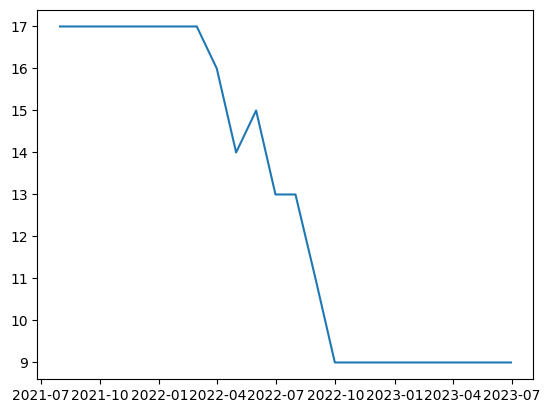

In [ ]:
# I'd like to look at the distribution of "non-zero" (e.g. greater than 0.1%) tickers
plt.plot(cnn_wts[cnn_wts > 0.001].nunique(axis=1))

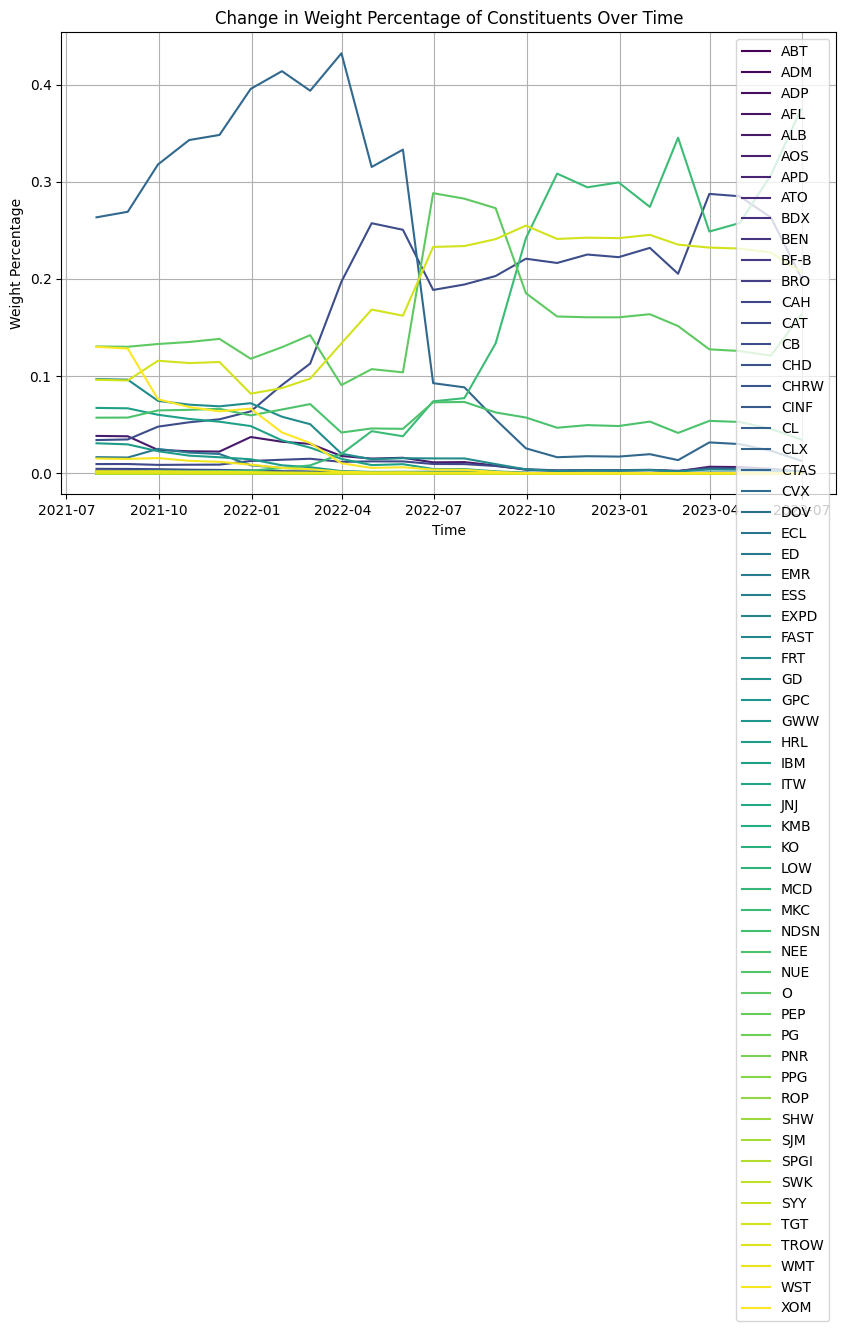

In [ ]:
colors = plt.cm.viridis(np.linspace(0, 1, asset_num))
plt.figure(figsize=(10,6))
for i in range(asset_num):
  plt.plot(cnn_wts.iloc[:, i], color=colors[i], label=dataset.Ticker[:asset_num][i])

plt.xlabel('Time')
plt.ylabel('Weight Percentage')
plt.title('Change in Weight Percentage of Constituents Over Time')
plt.legend()
plt.grid(True)
plt.show()

## Backtest Neural Network Models

In [ ]:
def perform_backtest(prices, model_preds):
  price_data = prices.drop(['MDT', 'LIN'], axis=1)
  # price_data = price_data[price_data.index.isin(date_index[n_train:])]
  price_data = price_data[price_data.index.isin(test_date_index)]
  price_data = price_data.sort_index()

  p_rets = []
  p_metrics = pd.DataFrame()

  for idx, preds in enumerate(model_preds):
    # portfolio value over time
    portfolio_value = (price_data * preds).sum(axis=1)

    # monthly portfolio returns
    portfolio_returns = portfolio_value.pct_change()
    p_rets.append(portfolio_returns)

    # total return, annualized return, Sharpe ratio, Volatility, Max Drawdown
    totalReturn = portfolio_value[-1] / portfolio_value[0] - 1
    years = len(portfolio_value) / 12
    annualReturn = ((portfolio_value[-1] / portfolio_value[0]) ** (1 / years)) - 1
    monthly_returns = portfolio_value.pct_change()
    sharpeRatio = (monthly_returns.mean() / monthly_returns.std()) * np.sqrt(12)
    volatility = monthly_returns.std() * np.sqrt(12)
    cumulative_returns = (1 + monthly_returns).cumprod()
    maxDrawdown = (cumulative_returns / cumulative_returns.cummax() - 1).min()

    nn_metrics = pd.DataFrame({f'NN{idx}':[totalReturn, annualReturn, sharpeRatio, volatility, maxDrawdown]})
    p_metrics = pd.concat([p_metrics, nn_metrics], axis=1)

  p_metrics.index = ['totalReturn', 'annualReturn', 'sharpeRatio', 'volatility', 'maxDrawdown']
  return p_rets, p_metrics

#### Equal-Weighted Portfolio

In [ ]:
ew_wts = pd.DataFrame(index=rnn_wts.index, columns=rnn_wts.columns)
ew_wts[:] = 1 / len(ew_wts.columns)
ew_wts

Ticker,ABT,ADM,ADP,AFL,ALB,AOS,APD,ATO,BDX,BEN,...,SHW,SJM,SPGI,SWK,SYY,TGT,TROW,WMT,WST,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2021-07-31,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,...,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02
2021-08-31,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,...,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02
2021-09-30,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,...,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02
2021-10-31,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,...,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02
2021-11-30,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,...,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02
2021-12-31,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,...,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02
2022-01-31,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,...,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02
2022-02-28,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,...,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02
2022-03-31,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,...,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02


In [ ]:
p_rets, p_metrics = perform_backtest(prices=data_m, model_preds=[mlp_wts, cnn_wts, rnn_wts, ew_wts])
p_rets_df = pd.concat(p_rets, axis=1).dropna()
p_rets_df.columns = ['MLP', 'CNN', 'RNN', 'EW']

<ipython-input-116-79e3448a91eb>:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  totalReturn = portfolio_value[-1] / portfolio_value[0] - 1
<ipython-input-116-79e3448a91eb>:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annualReturn = ((portfolio_value[-1] / portfolio_value[0]) ** (1 / years)) - 1
<ipython-input-116-79e3448a91eb>:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  totalReturn = portfolio_value[-1] / portfolio_val

In [ ]:
p_rets_df

,MLP,CNN,RNN,EW
Date,,,,
2021-08-31,0.01,0.02,0.04,0.02
2021-09-30,0.14,0.05,-0.02,-0.05
2021-10-31,0.10,0.15,0.02,0.08
2021-11-30,-0.04,-0.02,0.02,-0.01
2021-12-31,0.06,0.11,0.12,0.06
2022-01-31,-0.17,-0.06,-0.06,-0.07
2022-02-28,-0.08,-0.05,-0.08,-0.04
2022-03-31,-0.25,0.22,0.05,0.04
2022-04-30,-0.32,-0.14,-0.04,-0.04


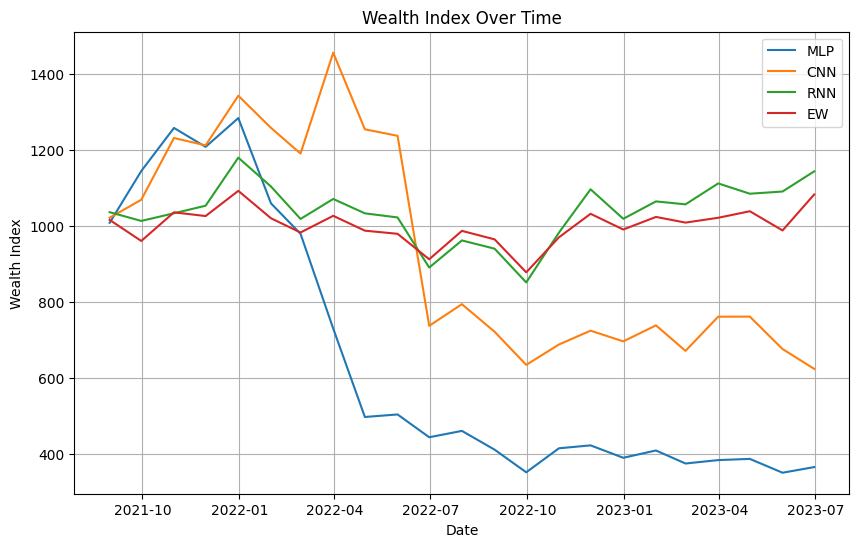

In [ ]:
wealth_index = 1000*(1+p_rets_df).cumprod()

plt.figure(figsize=(10, 6))
for column in wealth_index.columns:
    plt.plot(wealth_index.index, wealth_index[column], label=column)

plt.xlabel('Date')
plt.ylabel('Wealth Index')
plt.title('Wealth Index Over Time')
plt.legend()
plt.grid(True)
plt.show()

## Reinforcement Learning (RL)

In [ ]:
if not os.path.exists("/content/drive/My Drive/WQU_Capstone/Capstone Project/data/RL/datasets"):
    os.makedirs("/content/drive/My Drive/WQU_Capstone/Capstone Project/data/RL/datasets")
if not os.path.exists("/content/drive/My Drive/WQU_Capstone/Capstone Project/data/RL/trained_models"):
    os.makedirs("/content/drive/My Drive/WQU_Capstone/Capstone Project/data/RL/trained_models")
if not os.path.exists("/content/drive/My Drive/WQU_Capstone/Capstone Project/data/RL/tensorboard_log"):
    os.makedirs("/content/drive/My Drive/WQU_Capstone/Capstone Project/data/RL/tensorboard_log")
if not os.path.exists("/content/drive/My Drive/WQU_Capstone/Capstone Project/data/RL/results"):
    os.makedirs("/content/drive/My Drive/WQU_Capstone/Capstone Project/data/RL/results")

In [ ]:
# add covariance matrix as states
rl_df = dataset
rl_df.index = rl_df.Date.factorize()[0]

cov_list = []
return_list = []

# look back is one year
lookback=12
for i in range(lookback, len(rl_df.index.unique())):
  data_lookback = rl_df.loc[i-lookback:i,:]
  return_lookback = data_lookback.pivot_table(index = 'Date',columns = 'Ticker', values = 'ret')
  return_list.append(return_lookback)

  covs = return_lookback.cov().values
  cov_list.append(covs)

df_cov = pd.DataFrame({'Date':rl_df.Date.unique()[lookback:],'cov_list':cov_list,'return_list':return_list})
rl_df = rl_df.merge(df_cov, on='Date')
rl_df = rl_df.sort_values(['Date','Ticker']).reset_index(drop=True)
rl_df

,Date,Ticker,ret,dividendYield,payoutRatio,operatingcashFlowRatio,ROA,netProfitMargin,1 Yr,3 Yr,cov_list,return_list
0,2011-06-30,ABT,0.01,0.02,0.39,0.88,0.03,0.20,0.19,0.81,"[[0.002305626314804774, 0.001835166014818884, ...",Ticker ABT ADM ADP AFL ALB AOS...
1,2011-06-30,ADM,-0.07,0.01,0.27,2.19,0.01,0.02,0.19,0.81,"[[0.002305626314804774, 0.001835166014818884, ...",Ticker ABT ADM ADP AFL ALB AOS...
2,2011-06-30,ADP,-0.04,0.01,0.74,0.49,0.01,0.10,0.19,0.81,"[[0.002305626314804774, 0.001835166014818884, ...",Ticker ABT ADM ADP AFL ALB AOS...
3,2011-06-30,AFL,-0.02,0.02,0.46,-0.85,0.00,0.05,0.19,0.81,"[[0.002305626314804774, 0.001835166014818884, ...",Ticker ABT ADM ADP AFL ALB AOS...
4,2011-06-30,ALB,-0.02,0.00,0.13,0.59,0.03,0.16,0.19,0.81,"[[0.002305626314804774, 0.001835166014818884, ...",Ticker ABT ADM ADP AFL ALB AOS...
...,...,...,...,...,...,...,...,...,...,...,...,...
8840,2023-06-30,TGT,0.01,0.01,0.52,1.07,0.02,0.04,5.40,4.49,"[[0.003941050224425369, 0.002496377560835761, ...",Ticker ABT ADM ADP AFL ALB AOS...
8841,2023-06-30,TROW,0.06,0.01,0.59,0.49,0.04,0.30,5.40,4.49,"[[0.003941050224425369, 0.002496377560835761, ...",Ticker ABT ADM ADP AFL ALB AOS...
8842,2023-06-30,WMT,0.07,0.01,0.92,0.13,0.01,0.01,5.40,4.49,"[[0.003941050224425369, 0.002496377560835761, ...",Ticker ABT ADM ADP AFL ALB AOS...
8843,2023-06-30,WST,0.13,0.00,0.09,0.86,0.04,0.21,5.40,4.49,"[[0.003941050224425369, 0.002496377560835761, ...",Ticker ABT ADM ADP AFL ALB AOS...


In [ ]:
# monthly price data
price_data = data_m.drop(['MDT', 'LIN'], axis=1)
# price_data = price_data[price_data.index.isin(date_index[n_train:])]
price_data = price_data.sort_index()
price_long = price_data.reset_index().melt(id_vars=['Date'], var_name='Ticker', value_name='close')

In [ ]:
rl_df = price_long.merge(rl_df, on=['Date', 'Ticker']).drop('ret', axis=1)
rl_df = rl_df.sort_values(by=['Date', 'Ticker'])

## Build Environment

In [ ]:
# df_trainval
trainval_date_index[-1]
# df_test

Timestamp('2021-06-30 00:00:00')

In [ ]:
train_pct = 0.8
unique_dates = sorted(rl_df.Date.unique())
train_end_date = unique_dates[int(train_pct * len(unique_dates))]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
rl_train = rl_df.set_index('Date')
# rl_train = rl_train.loc[:train_end_date, :]
rl_train = rl_train.loc[:trainval_date_index[-1], :]
rl_train = rl_train.reset_index()
rl_train.index = rl_train.Date.factorize()[0]
rl_train

,Date,Ticker,close,dividendYield,payoutRatio,operatingcashFlowRatio,ROA,netProfitMargin,1 Yr,3 Yr,cov_list,return_list
0,2011-06-30,ABT,19.29,0.02,0.39,0.88,0.03,0.20,0.19,0.81,"[[0.002305626314804774, 0.001835166014818884, ...",Ticker ABT ADM ADP AFL ALB AOS...
0,2011-06-30,ADM,21.52,0.01,0.27,2.19,0.01,0.02,0.19,0.81,"[[0.002305626314804774, 0.001835166014818884, ...",Ticker ABT ADM ADP AFL ALB AOS...
0,2011-06-30,ADP,34.43,0.01,0.74,0.49,0.01,0.10,0.19,0.81,"[[0.002305626314804774, 0.001835166014818884, ...",Ticker ABT ADM ADP AFL ALB AOS...
0,2011-06-30,AFL,17.00,0.02,0.46,-0.85,0.00,0.05,0.19,0.81,"[[0.002305626314804774, 0.001835166014818884, ...",Ticker ABT ADM ADP AFL ALB AOS...
0,2011-06-30,ALB,57.81,0.00,0.13,0.59,0.03,0.16,0.19,0.81,"[[0.002305626314804774, 0.001835166014818884, ...",Ticker ABT ADM ADP AFL ALB AOS...
...,...,...,...,...,...,...,...,...,...,...,...,...
120,2021-06-30,TGT,226.08,0.00,0.16,0.06,0.04,0.09,0.07,0.46,"[[0.0028717702094912716, 1.2472444194352184e-0...",Ticker ABT ADM ADP AFL ALB AOS...
120,2021-06-30,TROW,177.79,0.01,0.31,0.67,0.07,0.42,0.07,0.46,"[[0.0028717702094912716, 1.2472444194352184e-0...",Ticker ABT ADM ADP AFL ALB AOS...
120,2021-06-30,WMT,45.08,0.01,0.57,0.08,0.01,0.02,0.07,0.46,"[[0.0028717702094912716, 1.2472444194352184e-0...",Ticker ABT ADM ADP AFL ALB AOS...
120,2021-06-30,WST,356.70,0.00,0.07,0.65,0.06,0.26,0.07,0.46,"[[0.0028717702094912716, 1.2472444194352184e-0...",Ticker ABT ADM ADP AFL ALB AOS...


In [ ]:
# rl_df.to_csv("/content/drive/My Drive/WQU_Capstone/Capstone Project/data/rl_df.csv", index=False)
# rl_train.to_csv("/content/drive/My Drive/WQU_Capstone/Capstone Project/data/rl_train.csv")

In [ ]:
class StockPortfolioEnv(gym.Env):
    """A single stock trading environment for OpenAI gym

    Attributes
    ----------
        df: DataFrame
            input data
        stock_dim : int
            number of unique stocks
        hmax : int
            maximum number of shares to trade
        initial_amount : int
            start money
        transaction_cost_pct: float
            transaction cost percentage per trade
        reward_scaling: float
            scaling factor for reward, good for training
        state_space: int
            the dimension of input features
        action_space: int
            equals stock dimension
        tech_indicator_list: list
            a list of technical indicator names
        turbulence_threshold: int
            a threshold to control risk aversion
        day: int
            an increment number to control date

    Methods
    -------
    _sell_stock()
        perform sell action based on the sign of the action
    _buy_stock()
        perform buy action based on the sign of the action
    step()
        at each step the agent will return actions, then
        we will calculate the reward, and return the next observation.
    reset()
        reset the environment
    render()
        use render to return other functions
    save_asset_memory()
        return account value at each time step
    save_action_memory()
        return actions/positions at each time step


    """
    metadata = {'render.modes': ['human']}

    def __init__(self,
                df,
                stock_dim,
                hmax, # max number of shares to trade
                initial_amount,
                transaction_cost_pct,
                reward_scaling,
                state_space,
                action_space,
                tech_indicator_list,
                turbulence_threshold=None,
                lookback=12,
                day = 0):
        #super(StockEnv, self).__init__()
        #money = 10 , scope = 1
        self.day = day
        self.lookback=lookback
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.transaction_cost_pct = transaction_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list

        # action_space normalization and shape is self.stock_dim
        self.action_space = spaces.Box(low = 0, high = 1,shape = (self.action_space,))
        # Shape = (34, 30)
        # covariance matrix + technical indicators
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape = (self.state_space+len(self.tech_indicator_list),self.state_space))

        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.terminal = False
        self.turbulence_threshold = turbulence_threshold
        # initalize state: inital portfolio return + individual stock return + individual weights
        self.portfolio_value = self.initial_amount

        # memorize portfolio value each step
        self.asset_memory = [self.initial_amount]
        # memorize portfolio return each step
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.Date.unique()[0]]


    def step(self, actions):
        self.terminal = self.day >= len(self.df.index.unique())-1

        if self.terminal:
            df = pd.DataFrame(self.portfolio_return_memory)
            df.columns = ['monthly_return']
            plt.plot(df.monthly_return.cumsum(),'r')
            plt.savefig("/content/drive/My Drive/WQU_Capstone/Capstone Project/data/RL/results/cumulative_reward.png")
            plt.close()

            plt.plot(self.portfolio_return_memory,'r')
            plt.savefig("/content/drive/My Drive/WQU_Capstone/Capstone Project/data/RL/results/rewards.png")
            plt.close()

            print("=================================")
            print("begin_total_asset:{}".format(self.asset_memory[0]))
            print("end_total_asset:{}".format(self.portfolio_value))

            df_monthly_return = pd.DataFrame(self.portfolio_return_memory)
            df_monthly_return.columns = ['monthly_return']
            if df_monthly_return['monthly_return'].std() !=0:
              sharpe = (12**0.5)*df_monthly_return['monthly_return'].mean()/ \
                       df_monthly_return['monthly_return'].std()
              print("Sharpe: ",sharpe)
            print("=================================")

            return self.state, self.reward, self.terminal,{}

        else:
            #print("Model actions: ",actions)
            # actions are the portfolio weight
            # normalize to sum of 1
            #if (np.array(actions) - np.array(actions).min()).sum() != 0:
            #  norm_actions = (np.array(actions) - np.array(actions).min()) / (np.array(actions) - np.array(actions).min()).sum()
            #else:
            #  norm_actions = actions
            weights = self.softmax_normalization(actions)
            #print("Normalized actions: ", weights)
            self.actions_memory.append(weights)
            last_day_memory = self.data

            #load next state
            self.day += 1
            self.data = self.df.loc[self.day,:]
            self.covs = self.data['cov_list'].values[0]
            self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
            #print(self.state)
            # calcualte portfolio return
            # individual stocks' return * weight
            portfolio_return = sum(((self.data.close.values / last_day_memory.close.values)-1)*weights)
            # update portfolio value
            new_portfolio_value = self.portfolio_value*(1+portfolio_return)
            self.portfolio_value = new_portfolio_value

            # save into memory
            self.portfolio_return_memory.append(portfolio_return)
            self.date_memory.append(self.data.Date.unique()[0])
            self.asset_memory.append(new_portfolio_value)

            # the reward is the new portfolio value or end portfolo value
            self.reward = new_portfolio_value
            #print("Step reward: ", self.reward)
            #self.reward = self.reward*self.reward_scaling

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [self.initial_amount]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        # load states
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.portfolio_value = self.initial_amount
        #self.cost = 0
        #self.trades = 0
        self.terminal = False
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.Date.unique()[0]]

        return self.state

    def render(self, mode='human'):
        return self.state

    def softmax_normalization(self, actions):
        numerator = np.exp(actions)
        denominator = np.sum(np.exp(actions))
        softmax_output = numerator/denominator
        return softmax_output


    def save_asset_memory(self):
        date_list = self.date_memory
        portfolio_return = self.portfolio_return_memory
        #print(len(date_list))
        #print(len(asset_list))
        df_account_value = pd.DataFrame({'date':date_list,'daily_return':portfolio_return})
        return df_account_value

    def save_action_memory(self):
        # date and close price length must match actions length
        date_list = self.date_memory
        df_date = pd.DataFrame(date_list)
        df_date.columns = ['Date']

        action_list = self.actions_memory
        df_actions = pd.DataFrame(action_list)
        df_actions.columns = self.data.tic.values
        df_actions.index = df_date.Date
        #df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

In [ ]:
stock_dimension = len(rl_train.Ticker.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 61, State Space: 61


In [ ]:
env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000,
    "transaction_cost_pct": 0.001,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": rl_train.columns[3:10],
    "action_space": stock_dimension,
    "reward_scaling": 1e-4

}

e_train_gym = StockPortfolioEnv(df = rl_train, **env_kwargs)

In [ ]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


/usr/local/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


## Use Different Agents

In [ ]:
agent = DRLAgent(env = env_train)

A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.0002}
model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS)

# this can be done for other agents plus custom agents as well
# custom will be important depending upon how we try new things

{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0002}
Using cpu device


In [ ]:
trained_a2c = agent.train_model(model=model_a2c,
                                tb_log_name='a2c',
                                total_timesteps=5000)

begin_total_asset:1000
end_total_asset:4227.864014317276
Sharpe:  1.1988363661466321
begin_total_asset:1000
end_total_asset:4333.814712485309
Sharpe:  1.2124922034013181
begin_total_asset:1000
end_total_asset:4180.469792782893
Sharpe:  1.1837825805127273
begin_total_asset:1000
end_total_asset:4375.426645054914
Sharpe:  1.2240227379592885
-------------------------------------
| time/                 |           |
|    fps                | 110       |
|    iterations         | 100       |
|    time_elapsed       | 4         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -86.4     |
|    explained_variance | -1.63e-05 |
|    learning_rate      | 0.0002    |
|    n_updates          | 99        |
|    policy_loss        | 2.81e+05  |
|    reward             | 1168.5149 |
|    std                | 0.997     |
|    value_loss         | 1.29e+07  |
-------------------------------------
begin_total_asset:1000
end_total_asset:4221.88576260

In [ ]:
trained_a2c.save("/content/drive/My Drive/WQU_Capstone/Capstone Project/data/RL/trained_models/trained_a2c.zip")

## Backtest RL

In [ ]:
rl_test = rl_df.set_index('Date')
rl_test = rl_test.loc[test_date_index[0]:, :]
rl_test = rl_test.reset_index()
rl_test.index = rl_test.Date.factorize()[0]
rl_test = rl_test.rename(columns={'Ticker':'tic'})
rl_test

,Date,tic,close,dividendYield,payoutRatio,operatingcashFlowRatio,ROA,netProfitMargin,1 Yr,3 Yr,cov_list,return_list
0,2021-07-31,ABT,115.07,0.00,0.68,0.88,0.02,0.12,0.07,0.35,"[[0.0026583283744045093, -0.000188816209082187...",Ticker ABT ADM ADP AFL ALB AOS...
0,2021-07-31,ADM,56.10,0.01,0.29,1.85,0.01,0.03,0.07,0.35,"[[0.0026583283744045093, -0.000188816209082187...",Ticker ABT ADM ADP AFL ALB AOS...
0,2021-07-31,ADP,198.20,0.00,0.74,1.41,0.01,0.14,0.07,0.35,"[[0.0026583283744045093, -0.000188816209082187...",Ticker ABT ADM ADP AFL ALB AOS...
0,2021-07-31,AFL,51.45,0.01,0.19,-1.06,0.01,0.20,0.07,0.35,"[[0.0026583283744045093, -0.000188816209082187...",Ticker ABT ADM ADP AFL ALB AOS...
0,2021-07-31,ALB,201.63,0.00,0.15,0.92,0.04,0.55,0.07,0.35,"[[0.0026583283744045093, -0.000188816209082187...",Ticker ABT ADM ADP AFL ALB AOS...
...,...,...,...,...,...,...,...,...,...,...,...,...
23,2023-06-30,TGT,128.49,0.01,0.52,1.07,0.02,0.04,5.40,4.49,"[[0.003941050224425369, 0.002496377560835761, ...",Ticker ABT ADM ADP AFL ALB AOS...
23,2023-06-30,TROW,108.30,0.01,0.59,0.49,0.04,0.30,5.40,4.49,"[[0.003941050224425369, 0.002496377560835761, ...",Ticker ABT ADM ADP AFL ALB AOS...
23,2023-06-30,WMT,51.84,0.01,0.92,0.13,0.01,0.01,5.40,4.49,"[[0.003941050224425369, 0.002496377560835761, ...",Ticker ABT ADM ADP AFL ALB AOS...
23,2023-06-30,WST,381.64,0.00,0.09,0.86,0.04,0.21,5.40,4.49,"[[0.003941050224425369, 0.002496377560835761, ...",Ticker ABT ADM ADP AFL ALB AOS...


In [ ]:
e_trade_gym = StockPortfolioEnv(df = rl_test, **env_kwargs)

In [ ]:
df_monthly_return, df_actions = DRLAgent.DRL_prediction(model=trained_a2c, environment = e_trade_gym)

/usr/local/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


begin_total_asset:1000
end_total_asset:1121.9001514455024
Sharpe:  0.3980663176077524
hit end!


In [ ]:
df_monthly_return.head()

,date,daily_return
0,2021-07-31,0.00
1,2021-08-31,0.02
2,2021-09-30,-0.05
3,2021-10-31,0.07
4,2021-11-30,-0.01


In [ ]:
df_actions.head()

,ABT,ADM,ADP,AFL,ALB,AOS,APD,ATO,BDX,BEN,...,SHW,SJM,SPGI,SWK,SYY,TGT,TROW,WMT,WST,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2021-07-31,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,...,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02
2021-08-31,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,...,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02
2021-09-30,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,...,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02
2021-10-31,0.02,0.02,0.01,0.02,0.02,0.01,0.01,0.01,0.01,0.01,...,0.02,0.01,0.02,0.01,0.01,0.02,0.01,0.01,0.01,0.02
2021-11-30,0.02,0.02,0.01,0.02,0.02,0.01,0.01,0.01,0.01,0.01,...,0.02,0.01,0.02,0.01,0.01,0.02,0.01,0.01,0.01,0.02


In [ ]:
df_actions.tail()

,ABT,ADM,ADP,AFL,ALB,AOS,APD,ATO,BDX,BEN,...,SHW,SJM,SPGI,SWK,SYY,TGT,TROW,WMT,WST,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2023-02-28,0.02,0.01,0.01,0.02,0.02,0.01,0.01,0.01,0.01,0.01,...,0.02,0.01,0.02,0.02,0.01,0.02,0.01,0.01,0.01,0.02
2023-03-31,0.02,0.01,0.01,0.02,0.02,0.01,0.01,0.01,0.01,0.01,...,0.02,0.01,0.02,0.02,0.01,0.02,0.01,0.01,0.01,0.02
2023-04-30,0.02,0.01,0.01,0.02,0.02,0.01,0.01,0.01,0.01,0.01,...,0.02,0.01,0.02,0.02,0.01,0.02,0.01,0.01,0.01,0.02
2023-05-31,0.02,0.01,0.01,0.02,0.02,0.01,0.01,0.01,0.01,0.01,...,0.02,0.01,0.02,0.02,0.01,0.02,0.01,0.01,0.01,0.02
2023-06-30,0.02,0.01,0.01,0.02,0.02,0.01,0.01,0.01,0.01,0.01,...,0.02,0.01,0.02,0.02,0.01,0.02,0.01,0.01,0.01,0.02


In [ ]:
rl_rets, rl_metrics = perform_backtest(prices=data_m, model_preds=[df_actions])
rl_rets = rl_rets[0].replace(np.inf, np.nan).dropna()
rl_rets.columns = ['RL']

<ipython-input-116-79e3448a91eb>:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  totalReturn = portfolio_value[-1] / portfolio_value[0] - 1
<ipython-input-116-79e3448a91eb>:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annualReturn = ((portfolio_value[-1] / portfolio_value[0]) ** (1 / years)) - 1


In [ ]:
rl_rets.head()

Date
2021-08-31    0.02
2021-09-30   -0.05
2021-10-31    0.08
2021-11-30   -0.01
2021-12-31    0.06
Freq: ME, dtype: float64

In [ ]:
rl_metrics

,NN0
totalReturn,0.09
annualReturn,0.04
sharpeRatio,0.31
volatility,0.20
maxDrawdown,-0.20


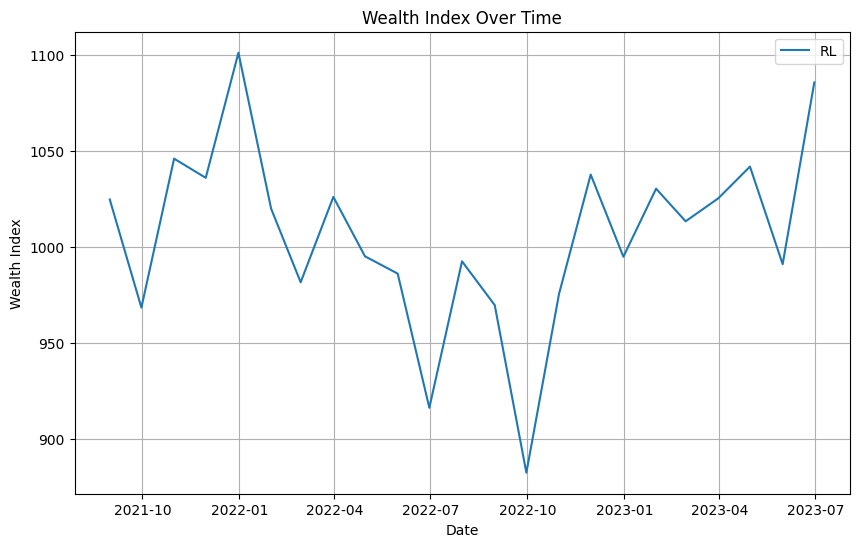

In [ ]:
wealth_index = 1000*(1+pd.DataFrame(rl_rets, columns=['RL'])).cumprod()

plt.figure(figsize=(10, 6))
for column in wealth_index.columns:
    plt.plot(wealth_index.index, wealth_index[column], label=column)

plt.xlabel('Date')
plt.ylabel('Wealth Index')
plt.title('Wealth Index Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Compare Results from RL vs. NNs vs. MVO